# Dense Face Estimation

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import deepmachine as dm
import scipy.io as sio
import matplotlib.pyplot as plt
import menpo.io as mio
from deepmachine import contrib
from scipy.ndimage.filters import gaussian_filter
from menpo.image import Image
from menpo.shape import PointCloud

%matplotlib inline

/Users/zha/miniconda2/envs/gitdev/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Dataset Visualize

In [2]:
def get_prediction(im, h, v):
    pts = []
    n_landmarks = template_landmarks.shape[0]
    regression_result = (np.array([h, v]))
    regression_result[regression_result<0] = np.inf

    for i in range(n_landmarks):
        if i<17:
            indices = np.unravel_index(
                np.argmin(((regression_result - (template_landmarks[i][:, None, None])).transpose(1,2,0) **2).sum(2) ), regression_result.shape)
            pts.append(indices[1:])
        else:
            indices = np.unravel_index(
                np.argmin(((regression_result - (template_landmarks[i][:, None, None])).transpose(1,2,0) **2).sum(2) ), regression_result.shape)
            pts.append(indices[1:])

    return ((np.array(pts)))

In [3]:
synthetic_pose = './data/300w_densereg_600x600.tfrecords'

In [4]:
tf.reset_default_graph()

filename_queue = tf.train.string_input_producer([synthetic_pose])
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

features = tf.parse_single_example(
    serialized_example,
    features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'uv': tf.FixedLenFeature([], tf.string),
        'image': tf.FixedLenFeature([], tf.string),
    })

tf_uv = tf.decode_raw(features['uv'], tf.float32)
tf_image = tf.image.decode_jpeg(features['image'], channels=3)
tf_image = tf.to_float(tf_image)

In [5]:
sess = tf.train.MonitoredSession()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [6]:
image, uv = sess.run([tf_image, tf_uv])

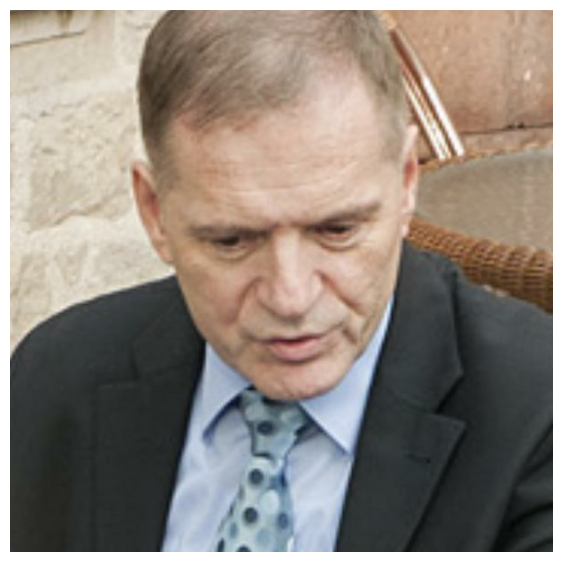

In [7]:
Image.init_from_channels_at_back(image / 255.).view()

In [8]:
uv_img = Image.init_from_channels_at_back(uv.reshape([600,600,3]))

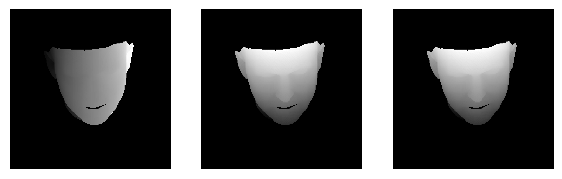

In [9]:
uv_img.view(channels=[0,1,2])

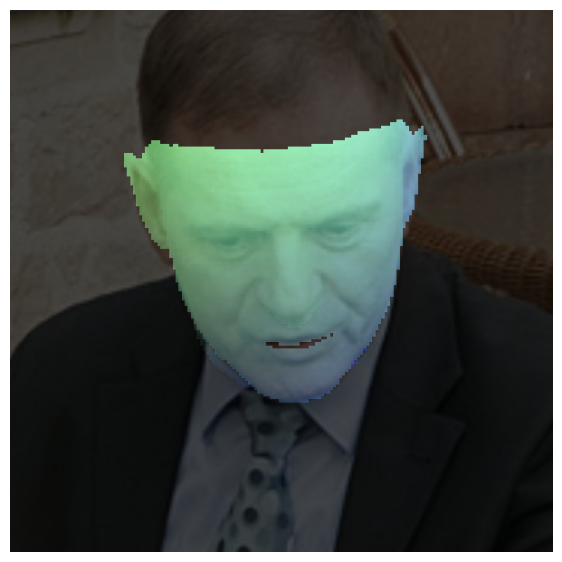

In [10]:
Image.init_from_channels_at_back(image / 255.).view()
Image.init_from_channels_at_back(dm.utils.svs_rgb(uv_img.pixels_with_channels_at_back()[..., :2])).view(alpha=0.7)

### Load Trained Model

In [11]:
model = contrib.densereg.get_densereg_face()

model.restore_path = './models/denseRegFace/dense_reg_model.ckpt'

In [12]:
model_lms = contrib.face.get_dense_cascade_face()

model_lms.restore_path = './models/denseRegFace/dense_reg_cascade_model.ckpt'

### Predict Dense Correspondency

In [34]:
def fill_hole_row(r):
    p_s = p_e = 0
    while p_e < len(r) and p_s < len(r):
        if r[p_s] == 0 and r[p_e] > 0 or p_e + 1 == len(r):
            start = r[p_s-1] if p_s > 0 else 0
            end = r[p_e] if r[p_e] > 0 else start
            r[p_s:p_e] = np.linspace(start, end, p_e-p_s)
            p_s = p_e = p_e + 1
        else:
            if r[p_e] == 0:
                p_e += 1
                
            if r[p_s] > 0:
                p_s += 1
                p_e = p_s

In [35]:
def fill_hole(img):
    img_hf = img.copy()
    for r in img_hf:
        fill_hole_row(r)

    for r in img_hf.T:
        fill_hole_row(r)
        
    return img_hf

In [13]:
input_image = mio.import_image('./resources/face_sample.png')
input_image = input_image.resize([256,256])

In [39]:
sigma = 9.
results = model.run_one(input_image.pixels_with_channels_at_back()[None, ...] * 255.)
results_lms = model_lms.run_one(input_image.pixels_with_channels_at_back()[None, ...])
heatmap_image = Image.init_from_channels_at_back(results_lms[1]['heatmap'][0])
uv_image = Image.init_from_channels_at_back(results[1]['uv'][0])
u_image = uv_image.pixels[:11].argmax(axis=0) / 9.
v_image = uv_image.pixels[11:].argmax(axis=0) / 9.
uv_mask = ((u_image > 0) + (v_image > 0)) > 0
u_image = fill_hole(u_image)
v_image = fill_hole(v_image)
uv_pixel_f = np.stack([
    gaussian_filter(u_image, sigma, mode='nearest'),
    gaussian_filter(v_image, sigma, mode='nearest')
], axis=-1) * uv_mask[...,None]

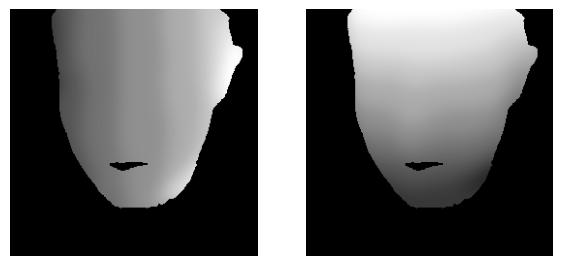

In [40]:
Image.init_from_channels_at_back(uv_pixel_f).view()

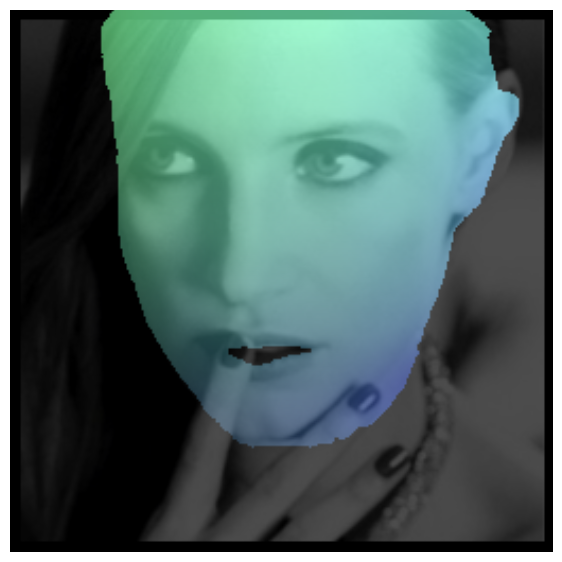

In [41]:
input_image.view()
Image.init_from_channels_at_back(dm.utils.svs_rgb(uv_pixel_f, colour_set='jet')).view(alpha=0.7)

#### Interpolate Sparse Information

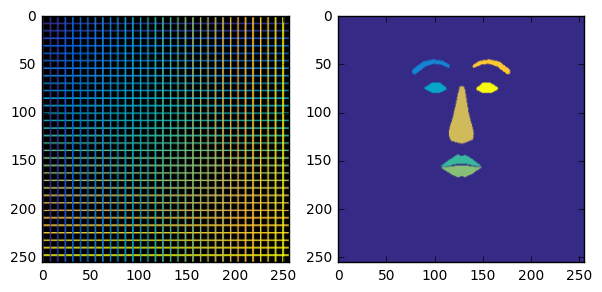

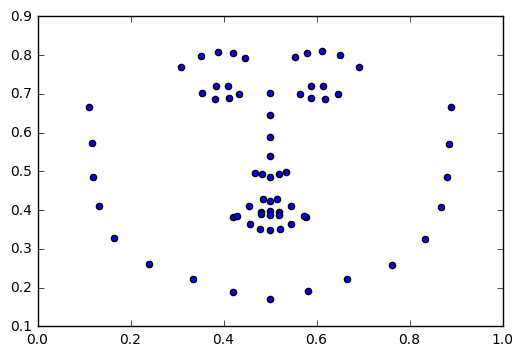

In [42]:
#Read Landmark Coordinates
template_landmarks = np.load('./data/face_template_data/template_landmarks.npy')
#Read Segmentation Map
L =  sio.loadmat('./data/face_template_data/SegLabelsColor.mat')
L_segments_color = Image.init_from_channels_at_back(L['L_color']).resize([256,256])
# Read 
L =  sio.loadmat('./data/face_template_data/Grid_color.mat')
L_grid_color = Image.init_from_channels_at_back(L['Grid_color']).resize([256,256])

# Visualization
f, axarr = plt.subplots(1, 2, figsize=(7,7))
axarr[0].imshow(L_grid_color.pixels_with_channels_at_back())
axarr[1].imshow(L_segments_color.pixels_with_channels_at_back())

plt.figure(2)
plt.scatter(template_landmarks[:,0],template_landmarks[:,1])


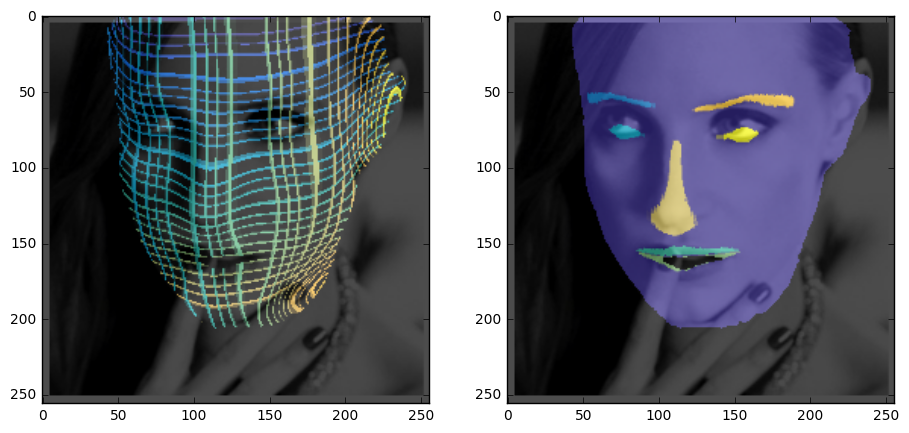

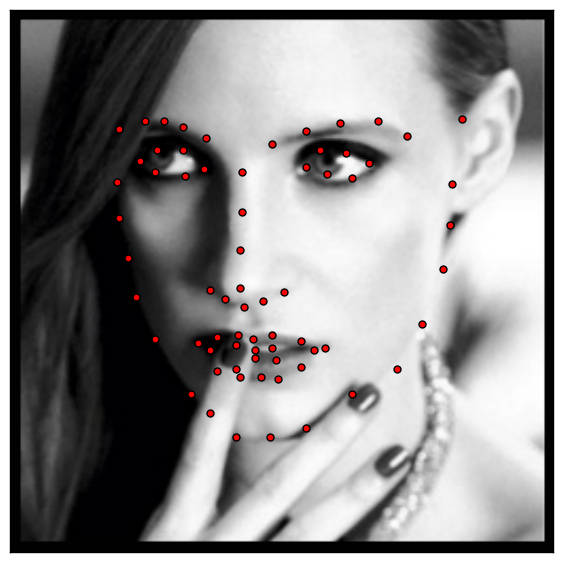

In [43]:
H = uv_pixel_f[...,0].astype(np.float32)
V = uv_pixel_f[...,1].astype(np.float32)
I_resized = input_image.pixels_with_channels_at_back()

Grid_interpolated = cv2.remap(L_grid_color.pixels_with_channels_at_back(), H * 256., 256. - V * 256.,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

Seg_interpolated = cv2.remap(L_segments_color.pixels_with_channels_at_back() , H * 256., 256. - V * 256.,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))

#visualize.
f, axarr = plt.subplots(1, 2, figsize=(11,11))
axarr[0].imshow(Grid_interpolated*0.7 + 0.3*I_resized)
axarr[1].imshow(Seg_interpolated*0.7 + 0.3*I_resized)
plt.figure()
input_image.view()
PointCloud(dm.utils.heatmap_to_lms(heatmap_image.pixels_with_channels_at_back())).view()